# Netflix Reviews Topic Modeling and Sentiment Analysis Project

The goal of this project is to analyze customer reviews of Netflix to gain a deeper understanding of customer sentiment and identify prominent topics discussed in the reviews. This analysis aims to reveal insights about user satisfaction, key issues faced by users, and general attitudes toward Netflix's services. The project is divided into two major components: data preprocessing and topic modeling and sentiment analysis.

### Part 1: Data Preprocessing and Topic Modeling

The dataset was first preprocessed using a combination of text-cleaning techniques from the NLTK (Natural Language Toolkit) library. 

After preprocessing, Latent Dirichlet Allocation (LDA) was used to perform topic modeling. LDA helped identify the most significant themes mentioned by Netflix users.
The resulting topics were then visualized using PyLDAvis, an interactive visualization tool that provided a graphical representation of topics, including their relevance and overlaps. This helped in understanding the different topics discussed in customer reviews, such as technical issues, subscription-related feedback, content preferences, and overall service satisfaction.

### Part 2: Sentiment Analysis Methods Comparison

The second part of the project focused on sentiment analysis of the reviews to determine whether the customer sentiments were positive, neutral, or negative. For this, we applied and compared different sentiment analysis approaches to assess which method yields the most reliable results for our dataset. 


## Import required packages

In [45]:
import pandas as pd  # Data manipulation and analysis (pip install pandas)
import re # essential library for text processing tasks
import string  # used to work with strings and text-related tasks (e.g., punctuation removal)
import numpy as np  # Numerical computations, arrays, and matrices (pip install numpy)
import matplotlib.pyplot as plt  # Plotting and visualizations (pip install matplotlib)
import seaborn as sns # Statistical data visualization (pip install seaborn)
import nltk # NLP toolkit; for tokenization, stopword removal (pip install nltk)
from nltk.tokenize import sent_tokenize, word_tokenize, MWETokenizer # Tokenizers for single/multi-word expressions
from nltk.stem import WordNetLemmatizer  # Lemmatizer to reduce words to their base or dictionary form
from nltk.tokenize import word_tokenize  # Tokenizer that splits strings into individual words
from nltk.corpus import wordnet # Interface to the WordNet lexical database for English
from nltk.probability import FreqDist  # Used for frequency distribution of words
from collections import Counter # Counter for counting occurrences of elements in a list
# nltk.download('all')
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder  # Bigram collocation finder
from nltk.sentiment import SentimentIntensityAnalyzer  # Pre-trained sentiment analyzer to derive sentiment scores
from transformers import AutoTokenizer, AutoModelForSequenceClassification # Tools for loading pre-trained transformer models for classification tasks
from transformers import pipeline  # Provides easy-to-use inference pipelines (e.g., for sentiment analysis)
from scipy.special import softmax  # Softmax function for converting logits to probabilities
import spacy  # Industrial-strength NLP library for text processing (pip install spacy)
from spacy.lang.en.stop_words import STOP_WORDS # predefined stopwords for English
# PyTorch currently supports Python versions up to 3.11. 
# Ensure your Python version is 3.11 or lower to avoid compatibility issues.
#!pip install torch torchvision 
import torch
import torchvision
from tqdm.notebook import tqdm # Progress bar visualization for loops, particularly in notebooks (pip install tqdm)
import gensim  # Topic modeling and document similarity (pip install gensim)
from gensim import corpora  # Corpus and dictionary creation for topic modeling
from gensim.models.ldamodel import LdaModel # Latent Dirichlet Allocation model for topic modeling
from textblob import TextBlob  # Sentiment analysis and text processing (pip install textblob)
from wordcloud import WordCloud  # Creates word cloud visuals (pip install wordcloud)
import pyLDAvis  # Interactive LDA visualization (pip install pyLDAvis)
import pyLDAvis.gensim  # pyLDAvis integration for gensim's LDA model to provide visualization support
import warnings  # Suppresses deprecation warnings
sia = SentimentIntensityAnalyzer() # Initialize Sentiment Intensity Analyzer for sentiment analysis using NLTK's VADER
warnings.simplefilter('ignore', category=DeprecationWarning)
plt.style.use('ggplot')

## Data Loading and High-Level EDA

In [46]:
df=pd.read_csv('data/netflix_reviews.csv')
df = df.head(900)
df.head()
#df['content_len'] = df['content'].apply(lambda x: len(x.split(' ')))

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,28f0b8f2-bb2d-4f68-8255-d61be1084067,Ram Sandeep,Not working,1,0,8.139.1 build 24 51108,2024-11-08 13:33:35,8.139.1 build 24 51108
1,a139e6b1-0160-4805-8f65-30447a3e4f93,Donald Chagut,mabviravira,5,0,NaN,2024-11-08 13:15:46,NaN
2,3ea9f296-2ef0-408c-8fdc-077d03ee7569,Mohd Shaifudin Mohd Ali,Oky,5,0,8.139.1 build 24 51108,2024-11-08 13:02:46,8.139.1 build 24 51108
3,e8290100-4afa-444f-8568-9a9b94682d2e,Gerardo Ruvalcaba,More expensive and more restrictions,1,0,8.139.1 build 24 51108,2024-11-08 12:58:01,8.139.1 build 24 51108
4,47c91094-d3bd-4c73-b5ba-211ca6ea5e4f,Clainah Briones,While watching it will suddenly stop playing i...,1,0,8.139.1 build 24 51108,2024-11-08 12:46:57,8.139.1 build 24 51108


In [47]:
df.describe(include='object')

,reviewId,userName,content,reviewCreatedVersion,at,appVersion
count,900,900,900,665,900,665
unique,897,890,820,83,900,83
top,81c756ff-c1d7-4e98-913c-619be0f3c39d,A Google user,Good,8.138.1 build 10 50974,2024-11-08 13:33:35,8.138.1 build 10 50974
freq,2,6,28,297,1,297


In [48]:
# Analyzing content structure before applying tokenization
print("Median content length:", df['content'].apply(len).median())
print("Median number of sentences:", df['content'].apply(lambda x: len(x.split('.'))).median())

Median content length: 39.0
Median number of sentences: 1.0


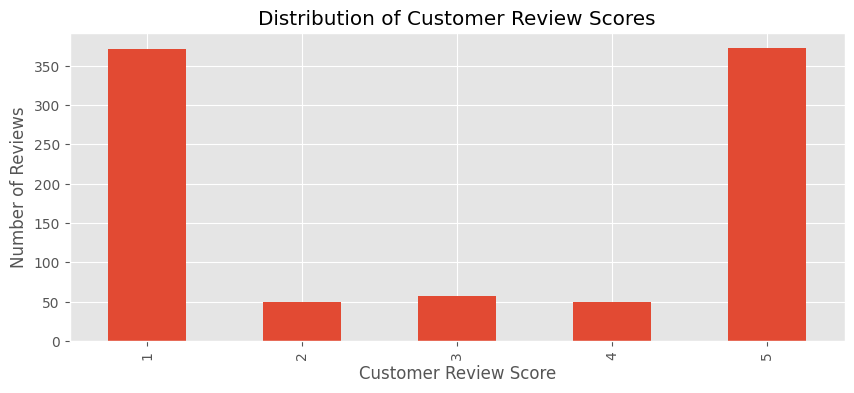

In [49]:
plt.figure(figsize=(10,4))
df['score'].value_counts().sort_index().plot(kind='bar')
plt.xlabel("Customer Review Score")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Customer Review Scores")
plt.show()

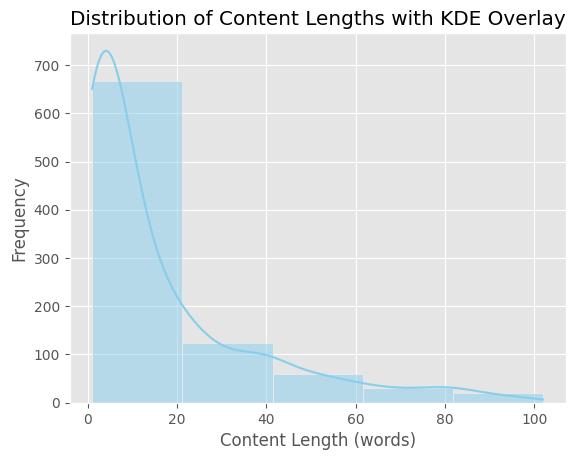

In [50]:
sns.histplot(df['content'].apply(lambda x: len(x.split(' '))), bins=5, kde=True, color='skyblue')
plt.xlabel("Content Length (words)")
plt.ylabel("Frequency")
plt.title("Distribution of Content Lengths with KDE Overlay")
plt.show()

## Basic NLTK

In this section, we will cover the basic Natural Language Processing (NLP) tasks:

1. **Text Cleaning and Preprocessing** - converting text to lowercase, removing punctuation and all symbols

2. **Stop Words Removal** - stop words are common words like "and", "the", "is". In this project they are removed as they don’t add significant meaning to the text

3. **Lemmatization**  - reduces words to their root forms (`WordNetLemmatizer` used)

4. **POS Tagging (Part-of-Speech Tagging)** - assigns parts of speech (e.g., noun, verb, adjective) to each word in a sentence, which helps in understanding the grammatical structure. (`pos_tag` used)

5. **Tokenization** - splits text into words ( `word_tokenize`used). Since most reviews have only 1 sentence, sentence-level tokenization would likely be ineffective 

6. **Collocation** - identify common phrases or expression

7. **Frequency Distribution** - a count of how frequently each word or token appears in a text. ( `FreqDist` function is used )

### **Text Cleaning and Preprocessing** 

In [51]:
def process_review(review):
    ''' Process review text by:
    - Converting to lowercase
    - Removing text in square brackets
    - Removing links
    - Removing punctuation
    - Removing newline characters
    - Removing words containing numbers
    - Removing HTML tags'''
    review = str(review).lower() # Make text lowercase
    review = re.sub(r'\[.*?\]', '', review)  # Remove text in square brackets
    review = re.sub(r'https?://\S+|www\.\S+', '', review)  # Remove URLs
    review = re.sub(r'<.*?>+', '', review)  # Remove HTML tags
    review = re.sub(rf"[{re.escape(string.punctuation)}]", '', review)  # Remove punctuation
    review = re.sub(r'\n', ' ', review)  # Replace newline characters with space
    review = re.sub(r'\w*\d\w*', '', review)  # Remove words containing digits
    review = re.sub(r'[\U0001F600-\U0001F64F]', '', review)  # Emoticons
    review = re.sub(r'[\U0001F300-\U0001F5FF]', '', review)  # Symbols & Pictographs
    review = re.sub(r'[\U0001F680-\U0001F6FF]', '', review)  # Transport & Map Symbols
    review = re.sub(r'[\U0001F700-\U0001F77F]', '', review)  # Alchemical Symbols
    review = re.sub(r'[\U0001F780-\U0001F7FF]', '', review)  # Geometric Shapes Extended
    review = re.sub(r'[\U0001F800-\U0001F8FF]', '', review)  # Supplemental Arrows-C
    review = re.sub(r'[\U0001F900-\U0001F9FF]', '', review)  # Supplemental Symbols and Pictographs
    review = re.sub(r'[\U0001FA00-\U0001FA6F]', '', review)  # Chess Symbols
    review = re.sub(r'[\U0001FA70-\U0001FAFF]', '', review)  # Symbols and Pictographs Extended-A
    review = re.sub(r'[\U00002702-\U000027B0]', '', review)  # Dingbats
    review = re.sub(r'[\U000024C2-\U0001F251]', '', review)  # Enclosed characters
    return review 


### Stop Words Removal &  Lematization & POS Tagging 

I chose **lemmatization** over **stemming** because:

- Lemmatization returns actual words that preserve meaning (e.g., "better" becomes "good" rather than "bet" or "bett"), making the text easier to analyze. 
Stemming often produces incomplete forms, like "happi" instead of "happy"
- Lemmatization considers context and part of speech, improving accuracy in sentiment analysis

In [52]:
spacy_stop_words = set(STOP_WORDS)
# print(spacy_stop_words )
stop_words = set(nltk.corpus.stopwords.words('english'))
# print(stop_words)
custom_stopwords = ['movie', 'film', 'series', 'netflix', 'app',  'please',  'watch', 'show','video', 'doesnt', 'episode','still']

def remove_stopwords(review):
    ''' 
    The function splits the review into words, removes common stopwords (defined in 'stop_words' and 'custom_stopwords'),
    and retains words with more than 5 characters. The processed words are joined back into a single string.
    '''
    review = ' '.join(word for word in review.split(' ') if word not in stop_words and word not in custom_stopwords and word not in spacy_stop_words and len(word)>2 )
    return review

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    '''
    The function uses the NLTK `pos_tag` to determine the POS tag of the word and then maps it to 
    a WordNet POS tag format (adjective, noun, verb, adverb) that is required by the lemmatizer.
    If the POS tag is not recognized, it defaults to noun.
    '''
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    # Default to noun if POS tag not found
    return tag_dict.get(tag, wordnet.NOUN)  

# Function to lemmatize each word in a review
def lemmatize_review(review):
    '''
    The function tokenizes the review into individual words and then lemmatizes each word using the 
    WordNet lemmatizer along with the POS tag obtained from `get_wordnet_pos()`. It also removes words 
    that are in the stopwords list or in the custom stopwords list.
    '''
    # Tokenize the review into words
    words = word_tokenize(review)
    # Lemmatize each word with its corresponding POS tag
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words if word not in stop_words and word not in custom_stopwords]
    # Join the lemmatized words back into a single string
    return ' '.join(lemmatized_words)

# Lets apply all modernisations to content column
df['clean_content'] = df['content'].apply(remove_stopwords).apply(process_review).apply(lemmatize_review).apply(remove_stopwords)
pd.set_option('display.max_rows', None)
df.head(5)

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion,clean_content
0,28f0b8f2-bb2d-4f68-8255-d61be1084067,Ram Sandeep,Not working,1,0,8.139.1 build 24 51108,2024-11-08 13:33:35,8.139.1 build 24 51108,work
1,a139e6b1-0160-4805-8f65-30447a3e4f93,Donald Chagut,mabviravira,5,0,NaN,2024-11-08 13:15:46,NaN,mabviravira
2,3ea9f296-2ef0-408c-8fdc-077d03ee7569,Mohd Shaifudin Mohd Ali,Oky,5,0,8.139.1 build 24 51108,2024-11-08 13:02:46,8.139.1 build 24 51108,oky
3,e8290100-4afa-444f-8568-9a9b94682d2e,Gerardo Ruvalcaba,More expensive and more restrictions,1,0,8.139.1 build 24 51108,2024-11-08 12:58:01,8.139.1 build 24 51108,expensive restriction
4,47c91094-d3bd-4c73-b5ba-211ca6ea5e4f,Clainah Briones,While watching it will suddenly stop playing i...,1,0,8.139.1 build 24 51108,2024-11-08 12:46:57,8.139.1 build 24 51108,suddenly stop play like freeze sound continues...


### Tokenization & Collocation & Frequency Distribution

In this section we look for bigrams (pairs of words that frequently appear together) 

In [53]:
### Tokenization
df['tokenized_content'] = df['clean_content'].apply(word_tokenize)

### Collocation - Finding Bigrams
bigram_finder = BigramCollocationFinder.from_words([word for tokens in df['tokenized_content'] for word in tokens])
# Apply frequency filter to consider only frequent bigrams
bigram_finder.apply_freq_filter(2)
# Find top bigrams based on likelihood ratio
top_bigrams = bigram_finder.nbest(BigramAssocMeasures.likelihood_ratio, 500)
print("Top Bigrams (Collocations):", top_bigrams)

### Frequency Distribution - Words and Bigrams

# Frequency Distribution of Words
all_words = [word for tokens in df['tokenized_content'] for word in tokens]
fdist_words = FreqDist(all_words)
print("Top 15 Words:")
for word, frequency in fdist_words.most_common(15):
    print(f'{word}: {frequency}')

# Frequency Distribution of Bigrams
bigram_list = list(bigram_finder.ngram_fd.items())
bigram_freq = Counter(bigram_list)
print("Top 15 Bigrams:")
for phrase, frequency in bigram_freq.most_common(15):
    print(f'{phrase}: {frequency}')

#df.head(5)


Top Bigrams (Collocations): [('ott', 'platform'), ('customer', 'service'), ('playback', 'speed'), ('black', 'screen'), ('password', 'share'), ('amazon', 'prime'), ('truck', 'driver'), ('walk', 'dead'), ('fast', 'forward'), ('suddenly', 'disappear'), ('increase', 'price'), ('waste', 'money'), ('fix', 'issue'), ('wont', 'let'), ('dekh', 'pate'), ('dekhi', 'hue'), ('dragon', 'ball'), ('south', 'african'), ('past', 'week'), ('user', 'friendly'), ('cancel', 'subscription'), ('collaboration', 'lodo'), ('power', 'ranger'), ('long', 'time'), ('work', 'properly'), ('play', 'store'), ('pls', 'fix'), ('clearing', 'cache'), ('rating', 'ludo'), ('yes', 'ive'), ('restart', 'phone'), ('lodo', 'king'), ('tak', 'boleh'), ('screenshot', 'scene'), ('english', 'dubbed'), ('poor', 'form'), ('prime', 'disney'), ('google', 'apple'), ('visa', 'card'), ('month', 'ago'), ('blame', 'internet'), ('low', 'set'), ('recommendation', 'repeat'), ('audio', 'play'), ('cancel', 'membership'), ('crack', 'password'), ('aat

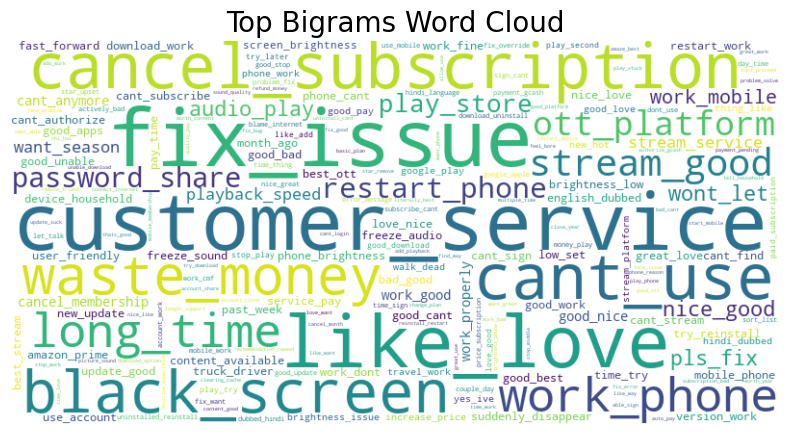

In [54]:
# Generate the word cloud for Bigrams
top_bigrams_freq = {('_'.join(bigram)): count for bigram, count in bigram_freq if bigram[0] != bigram[1]}
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(top_bigrams_freq)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top Bigrams Word Cloud", fontsize=20)
plt.show()

##  Topic Discovery with Latent Dirichlet Allocation (LDA)

 LDA helps identify latent topics that are not explicitly stated but can be inferred from patterns of words across different reviews. 

In [55]:
documents = [[bigram] * count for bigram, count in top_bigrams_freq.items()]

# Create a document list, where each document is just a list of bigram strings
flattened_documents = [bigram for sublist in documents for bigram in sublist]
# Create a single document from the flattened list to use in LDA
all_bigrams_document = ' '.join(flattened_documents).split()  # This treats all bigrams as a single "document"
# Create a Gensim dictionary from the list of bigrams
dictionary = corpora.Dictionary([all_bigrams_document])
# Create a Bag of Words (BoW) corpus from the dictionary
corpus = [dictionary.doc2bow([bigram]) for bigram in all_bigrams_document]

print(dictionary.token2id)  # View the bigram dictionary (token to id mapping)
print(corpus[:10])  # View a sample of the corpus (BoW format)

# Train an LDA model using the corpus
num_topics = 3
# Create an LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, passes=20, iterations=300)
# Print the topics
for idx, topic in lda_model.print_topics(num_topics=num_topics, num_words=5):
    print(f"Topic #{idx}: {topic}")

# Visualize the Topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model,corpus,dictionary,sort_topics=False)
pyLDAvis.save_html(vis, 'LDA_vis.html') #save 
pyLDAvis.display(vis)

{'aati_hai': 0, 'able_sign': 1, 'able_view': 2, 'absolutely_love': 3, 'account_close': 4, 'account_share': 5, 'account_travel': 6, 'account_work': 7, 'activate_extra': 8, 'actively_bad': 9, 'add_dragon': 10, 'add_playback': 11, 'add_work': 12, 'allow_use': 13, 'amaze_best': 14, 'amazon_prime': 15, 'audio_play': 16, 'authorize_gcash': 17, 'auto_pay': 18, 'bad_cant': 19, 'bad_experience': 20, 'bad_good': 21, 'basic_plan': 22, 'best_apps': 23, 'best_good': 24, 'best_ott': 25, 'best_stream': 26, 'black_screen': 27, 'blame_internet': 28, 'brightness_control': 29, 'brightness_issue': 30, 'brightness_low': 31, 'brightness_phone': 32, 'brightness_scale': 33, 'brightness_setting': 34, 'cancel_membership': 35, 'cancel_month': 36, 'cancel_subscription': 37, 'cant_able': 38, 'cant_anymore': 39, 'cant_authorize': 40, 'cant_download': 41, 'cant_find': 42, 'cant_install': 43, 'cant_log': 44, 'cant_login': 45, 'cant_open': 46, 'cant_pay': 47, 'cant_phone': 48, 'cant_play': 49, 'cant_proceed': 50, 'can

## Sentiment Analysis
In this section, we explore the sentiment of Netflix user reviews by applying Natural Language Processing (NLP) techniques to determine whether the sentiments expressed in the reviews are positive or negative.

We explore 3 different approaches to gain insights into how they perform, particularly with challenging language phenomena such as sarcasm. Each approach has unique strengths, and by comparing them, we aim to better understand their effectiveness and limitations.

BTW, in the previous topic analysis, we applied preprocessing steps such as stopword removal and lemmatization to clean and simplify the textual data. These techniques were used to reduce noise and improve the quality of text data for topic modeling. 

However, for sentiment analysis, I would prefer to avoid using these preprocessing steps for the following reasons:
1. Words like "not", "never", and "no" are often included in standard stopword lists, but these are crucial for determining the sentiment of a sentence.
For example, "not working" versus "work" completely changes the sentiment. 
2. Lemmatization indeed might simplify the text but can also lead to loss of intensity. For example: By changing "amazing" to "amaze", the model’s ability to capture the emotional strength of the sentiment can be reduced.

In [56]:
df['clean_content'] = df['content'].apply(process_review)

###  1. TextBlob Sentiment Analysis 
TextBlob is a simple straightforward sentiment analysis tool that calculates 2 metrics:

1. Polarity - a scale that indicates how positive, negative, or neutral a piece of text is. Usually from -1 to 1, where 1 is a positive sentiment and -1 - negative.
2. Subjectivity - measures how subjective (e.g., "I think this movie is wonderful") or objective (e.g., "The movie was released in 2021") a piece of text is. Usually from 0 to 1, where the closer to 1 the more personal opinion it is

Althoug this works well with basic sentiment analysis tasks, it often fails to recognize sarcasm or complex linguistic structures because it relies purely on the presence of positive or negative words.

In [57]:
# Calculate the polarity and subjectivity
df['polarity']=df['clean_content'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity']=df['clean_content'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
# Categorize the subjectivity score: scores below 0.5 are classified as "Objective," and scores equal to or above 0.5 are classified as "Subjective"
df['subjectivity_category'] = df['subjectivity'].apply(lambda x: 'Objective' if x < 0.5 else 'Subjective')
# Categorize the polarity into sentiment categories:
df['polarity_category'] = df['polarity'].apply(lambda x: 'Negative' if x < 0 else ('Neutral' if x == 0 else 'Positive'))

df.head(5)

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion,clean_content,tokenized_content,polarity,subjectivity,subjectivity_category,polarity_category
0,28f0b8f2-bb2d-4f68-8255-d61be1084067,Ram Sandeep,Not working,1,0,8.139.1 build 24 51108,2024-11-08 13:33:35,8.139.1 build 24 51108,not working,[work],0.000000,0.000000,Objective,Neutral
1,a139e6b1-0160-4805-8f65-30447a3e4f93,Donald Chagut,mabviravira,5,0,NaN,2024-11-08 13:15:46,NaN,mabviravira,[mabviravira],0.000000,0.000000,Objective,Neutral
2,3ea9f296-2ef0-408c-8fdc-077d03ee7569,Mohd Shaifudin Mohd Ali,Oky,5,0,8.139.1 build 24 51108,2024-11-08 13:02:46,8.139.1 build 24 51108,oky,[oky],0.000000,0.000000,Objective,Neutral
3,e8290100-4afa-444f-8568-9a9b94682d2e,Gerardo Ruvalcaba,More expensive and more restrictions,1,0,8.139.1 build 24 51108,2024-11-08 12:58:01,8.139.1 build 24 51108,more expensive and more restrictions,"[expensive, restriction]",0.166667,0.566667,Subjective,Positive
4,47c91094-d3bd-4c73-b5ba-211ca6ea5e4f,Clainah Briones,While watching it will suddenly stop playing i...,1,0,8.139.1 build 24 51108,2024-11-08 12:46:57,8.139.1 build 24 51108,while watching it will suddenly stop playing i...,"[suddenly, stop, play, like, freeze, sound, co...",0.300000,0.466667,Objective,Positive


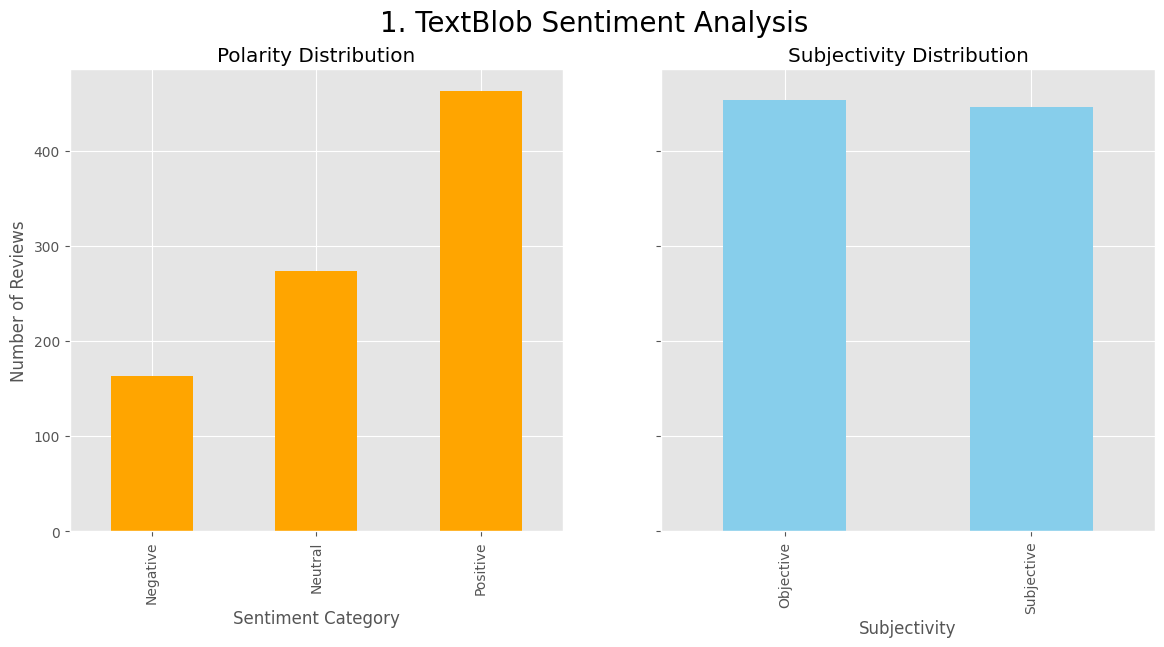

In [58]:
# Plotting and visualizing the counts:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
# Plot for Polarity
df['polarity_category'].value_counts().sort_index().plot(kind = 'bar', ax=axes[0], color='orange')
axes[0].set_title('Polarity Distribution')
axes[0].set_xlabel('Sentiment Category')
axes[0].set_ylabel('Number of Reviews')

# Plot for Subjectivity
df['subjectivity_category'].value_counts().sort_index().plot(kind = 'bar', ax=axes[1],  color='skyblue')
axes[1].set_title('Subjectivity Distribution')
axes[1].set_xlabel('Subjectivity')
fig.suptitle("1. TextBlob Sentiment Analysis", fontsize=20)

plt.show()

Standard sentiment analysis methods, like the one we used - polarity and subjectivity scores, often fail with sarcastic expressions. 

To improve sentiment analysis, we will try second more advanced approach 

## 2. Transformer-Based Sentiment Analysis with Pre-trained Model
This method leverages a pre-trained transformer model from Hugging Face, which provides sentiment classification across five classes (ranging from 1 star to 5 stars).

In [ ]:
# Load a sentiment-analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Apply the sentiment model
df['transformer_sentiment'] = df['clean_content'].apply(lambda x: sentiment_pipeline(x)[0]['label'])
def map_stars_to_sentiment(star_rating):
    star = int(star_rating.split()[0])
    if star in [1, 2]:
        return 'Negative'
    elif star == 3:
        return 'Neutral'
    else:  
        return 'Positive'
df['transformer_sentiment'] = df['transformer_sentiment'].apply(map_stars_to_sentiment)
df.head()


,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion,clean_content,tokenized_content,polarity,subjectivity,subjectivity_category,polarity_category,transformer_sentiment
0,28f0b8f2-bb2d-4f68-8255-d61be1084067,Ram Sandeep,Not working,1,0,8.139.1 build 24 51108,2024-11-08 13:33:35,8.139.1 build 24 51108,not working,[work],0.000000,0.000000,Objective,Neutral,Negative
1,a139e6b1-0160-4805-8f65-30447a3e4f93,Donald Chagut,mabviravira,5,0,NaN,2024-11-08 13:15:46,NaN,mabviravira,[mabviravira],0.000000,0.000000,Objective,Neutral,Neutral
2,3ea9f296-2ef0-408c-8fdc-077d03ee7569,Mohd Shaifudin Mohd Ali,Oky,5,0,8.139.1 build 24 51108,2024-11-08 13:02:46,8.139.1 build 24 51108,oky,[oky],0.000000,0.000000,Objective,Neutral,Neutral
3,e8290100-4afa-444f-8568-9a9b94682d2e,Gerardo Ruvalcaba,More expensive and more restrictions,1,0,8.139.1 build 24 51108,2024-11-08 12:58:01,8.139.1 build 24 51108,more expensive and more restrictions,"[expensive, restriction]",0.166667,0.566667,Subjective,Positive,Negative
4,47c91094-d3bd-4c73-b5ba-211ca6ea5e4f,Clainah Briones,While watching it will suddenly stop playing i...,1,0,8.139.1 build 24 51108,2024-11-08 12:46:57,8.139.1 build 24 51108,while watching it will suddenly stop playing i...,"[suddenly, stop, play, like, freeze, sound, co...",0.300000,0.466667,Objective,Positive,Negative


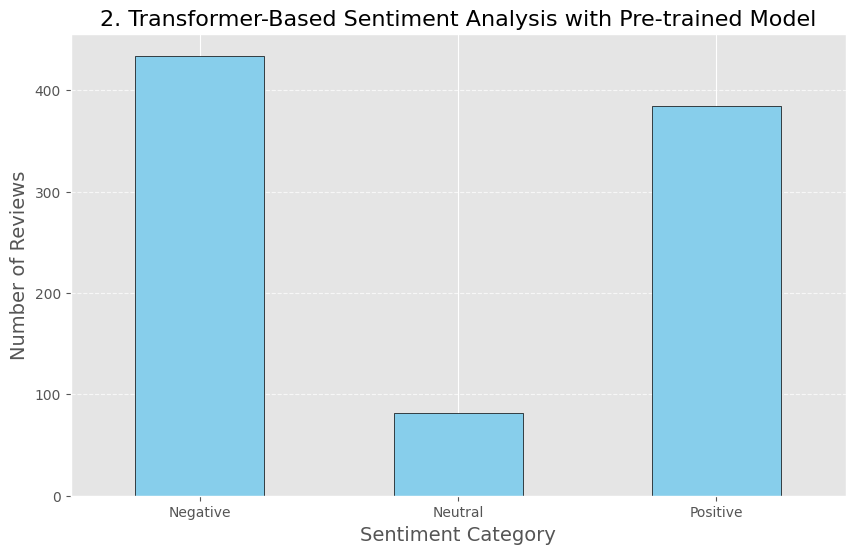

In [60]:
plt.figure(figsize=(10, 6))
df['transformer_sentiment'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('2. Transformer-Based Sentiment Analysis with Pre-trained Model', fontsize=16)
plt.xlabel('Sentiment Category', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xticks(rotation=0)  # Keep the labels horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: Adding a grid for better readability
plt.show()

## 3. Transformer-Based Sentiment Analysis with RoBERTa (Sarcasm-Sensitive Analysis)
This model is particularly focused on social media data, making it better suited for sarcastic or informal language, which is typical in review data.

In [69]:
# Load the tokenizer and model for a multi-class sentiment analysis
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

# Apply the model to classify sentiment
def get_sentiment(text):
    # Tokenize the input text and truncate if needed
    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True)
    
    # Perform the prediction
    outputs = model(**inputs)
    
    # Get scores and find the label with the highest score
    scores = outputs.logits.softmax(dim=-1)
    labels = ['Negative', 'Neutral', 'Positive']
    sentiment = labels[torch.argmax(scores)]
    
    return sentiment

# Apply the function to the dataframe
df['RoBERTa_sentiment'] = df['clean_content'].apply(get_sentiment)

# Display the output
print(df[['clean_content', 'RoBERTa_sentiment', 'score']].head())

                                       clean_content RoBERTa_sentiment  score
0                                        not working          Negative      1
1                                        mabviravira           Neutral      5
2                                                oky           Neutral      5
3               more expensive and more restrictions          Negative      1
4  while watching it will suddenly stop playing i...          Negative      1


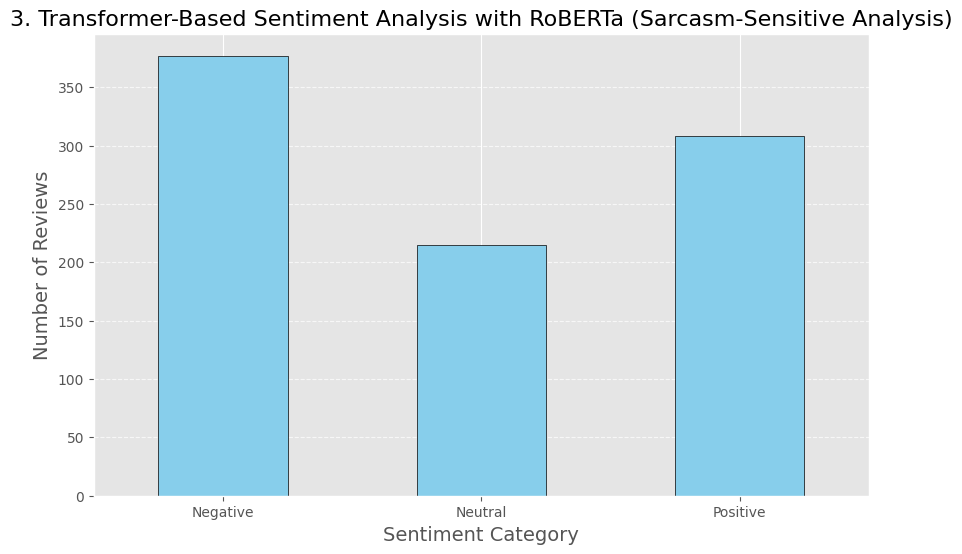

In [62]:
plt.figure(figsize=(10, 6))
df['RoBERTa_sentiment'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('3. Transformer-Based Sentiment Analysis with RoBERTa (Sarcasm-Sensitive Analysis)', fontsize=16)
plt.xlabel('Sentiment Category', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
plt.xticks(rotation=0)  # Keep the labels horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: Adding a grid for better readability
plt.show()

In [ ]:
pd.set_option('display.width', 1000)  
pd.set_option('display.max_columns', None) 
print(df[['clean_content', 'polarity_category', 'transformer_sentiment','RoBERTa_sentiment', 'score']].head(10))


                                        clean_content polarity_category transformer_sentiment RoBERTa_sentiment  score
0                                         not working           Neutral              Negative          Negative      1
1                                         mabviravira           Neutral               Neutral           Neutral      5
2                                                 oky           Neutral               Neutral           Neutral      5
3                more expensive and more restrictions          Positive              Negative          Negative      1
4   while watching it will suddenly stop playing i...          Positive              Negative          Negative      1
5                                                nice          Positive              Positive          Positive      5
6                  login problem very lengthy process          Positive              Negative          Negative      1
7   rate to the lowest i downloaded some movies 

## Sentiment Analysis Comparison

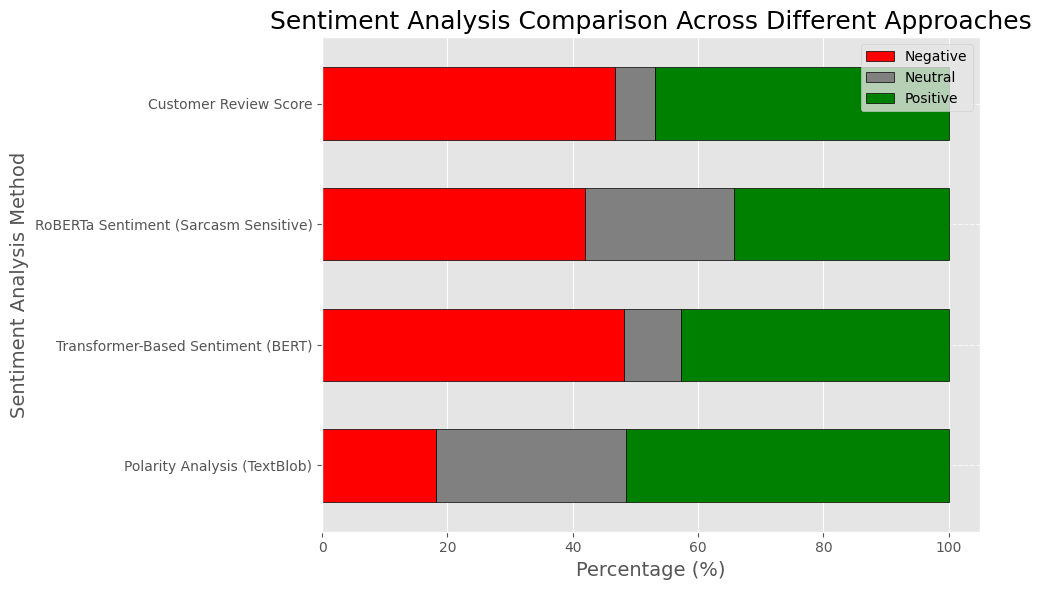

In [65]:
# Step 1: Map Scores to Sentiment Categories (Negative, Neutral, Positive)
def map_score_to_sentiment(score):
    if score in [1, 2]:
        return 'Negative'
    elif score == 3:
        return 'Neutral'
    else:  # 4 or 5 stars
        return 'Positive'

# Create a new column that represents the sentiment category from customer review scores
df['score_sentiment_category'] = df['score'].apply(map_score_to_sentiment)

# Get the value counts for each of the sentiment approaches
polarity_counts = df['polarity_category'].value_counts().reindex(['Negative', 'Neutral', 'Positive'], fill_value=0)
transformer_counts = df['transformer_sentiment'].value_counts().reindex(['Negative', 'Neutral', 'Positive'], fill_value=0)
roberta_counts = df['RoBERTa_sentiment'].value_counts().reindex(['Negative', 'Neutral', 'Positive'], fill_value=0)
score_counts = df['score_sentiment_category'].value_counts().reindex(['Negative', 'Neutral', 'Positive'], fill_value=0)

# Combine all value counts into a DataFrame and fill NaN values with 0
combined_counts = pd.DataFrame({
    'Polarity Analysis (TextBlob)': polarity_counts,
    'Transformer-Based Sentiment (BERT)': transformer_counts,
    'RoBERTa Sentiment (Sarcasm Sensitive)': roberta_counts,
    'Customer Review Score':score_counts
}).fillna(0)

# Calculate the percentage distribution for the 100% stacked bar chart
combined_percentage = combined_counts.apply(lambda x: x / x.sum() * 100)

# Step 2: Create the Combined Chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the 100% stacked bar chart
colors = ['red', 'grey', 'green']  # Red for Negative, Grey for Neutral, Green for Positive
combined_percentage.T.plot(kind='barh', stacked=True, ax=ax, color=colors, edgecolor='black', width=0.6)

# Set titles and labels
ax.set_title('Sentiment Analysis Comparison Across Different Approaches', fontsize=18)
ax.set_xlabel('Percentage (%)', fontsize=14)
ax.set_ylabel('Sentiment Analysis Method', fontsize=14)

# Step 3: Plot the Red Line for Customer Review Score Distribution
score_percentage = (score_counts / score_counts.sum() * 100).reindex(['Negative', 'Neutral', 'Positive']).fillna(0)

# Add legend and grid
ax.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

In the above chart, we compared 3 different sentiment analysis methods: Polarity Analysis (TextBlob), Transformer-Based Sentiment Analysis (BERT), RoBERTa Sentiment Analysis with the Customer Review Score (used as a benchmark). 

Overall, based on this analysis, BERT and RoBERTa demonstrate a sentiment distribution that is more aligned with actual customer review scores, making them more reliable choices for sentiment analysis tasks. The major advantage lies in their ability to understand context, manage negations, and correctly identify sentiments within complex phrases, whereas TextBlob falls short in such scenarios due to its rule-based limitations.

Thus, using more advanced transformer-based models like BERT or RoBERTa is advisable for achieving higher accuracy in sentiment analysis, especially for customer reviews that often include sarcasm or intricate phrasing.